In [1]:
# Import the torch module for tensor computation and deep learning
import torch
print(1)
# Import the matplotlib.pyplot module for creating static, animated, and interactive visualizations in Python
import matplotlib.pyplot as plt
print(2)
# Import the numpy module for numerical operations in Python
import numpy as np
print(3)
# Import the nn module from torch for building neural networks
import torch.nn as nn
print(4)
# Import the transformers, datasets, evaluate, datasets, huggingface_hub modules for working with transformer models, datasets, evaluation metrics, and Hugging Face's hub
import transformers
print(5)
import datasets
print(5.1)
import evaluate
print(5.2)
import datasets
print(5.3)
import huggingface_hub
print(6)
import albumentations as A
print(7)
# Import the ColorJitter class from torchvision.transforms for randomly changing the brightness, contrast, and saturation of an image

# Import the load_dataset function from the datasets module for loading datasets
from datasets import load_dataset

# Import the TrainingArguments and Trainer classes from the transformers module for setting training arguments and training transformer models
from transformers import TrainingArguments, Trainer

# Import the notebook_login function from the huggingface_hub module for logging in to Hugging Face's hub
from huggingface_hub import notebook_login

# Import the accelerate module for accelerating PyTorch code with mixed precision and distributed training
import accelerate

# Import the Accelerator class from the accelerate module for accelerating PyTorch code
from accelerate import Accelerator

# Import the pipeline function from the transformers module for creating a pipeline that processes and returns the model's output
from transformers import pipeline

# Import the Image class from the PIL module for opening, manipulating, and saving many different image file formats
from PIL import Image

# Import the glob function from the glob module for finding all the pathnames matching a specified pattern
from glob import glob

# Import the SegformerImageProcessor, SegformerModel, SegformerConfig, AutoImageProcessor, SegformerForSemanticSegmentation classes from the transformers module for working with Segformer models
from transformers import SegformerImageProcessor, SegformerModel, SegformerConfig, AutoImageProcessor, SegformerForSemanticSegmentation

# Set the allow_tf32 attribute of torch.backends.cuda.matmul to True to allow TensorFloat-32 (TF32) on Ampere devices
torch.backends.cuda.matmul.allow_tf32 = True

# This code imports necessary modules and functions for a machine learning task. It sets up for tensor computations, deep learning, data visualization, working with transformer models, datasets, image manipulations, and more. It also logs into Hugging Face's hub.

# This sets the model's huggingface URL for uploading and downloading the model
hf_model_name = "glacierscopessegmentation/glacier_segmentation_transformer"


1
2
3
4
5
5.1
5.2
5.3
6
7


In [ ]:
# Call the notebook_login function to log in to Hugging Face's hub
# notebook_login()

# make sure to login, or use the huggingface-cli to login, that way you can actually sync the model
# the login for the dataset only works for Aashray and Brian soo... yeah! Email me to get access to the dataset and model at aashraychegu@hotmail.com

In [22]:
# Load a dataset from Hugging Face's hub using the specified repository name
ds = load_dataset("glacierscopessegmentation/secondleg")

# Split the "train" subset of the dataset into a training set and a test set, with 5% of the data going to the test set
ds = ds["train"].train_test_split(.05)
# The 5% split is a bit little, but this has to be done or else the evaluation function takes forever

# Assign the "train" subset of the split dataset to the variable train_ds
train_ds = ds["train"]

# Assign the "test" subset of the split dataset to the variable test_ds
test_ds = ds["test"]

# Define a dictionary mapping label IDs to their corresponding names
id2label = {
    "0": "sky", # This is given by the rgb value of 00 00 00 for the mask
    "1": "surface-to-bed", # This is given by the rgb value of 01 01 01 for the mask
    "2": "bed-to-bottom", # This is given by the rgb value of 02 02 02 for the mask
}

# Convert the keys of the id2label dictionary from strings to integers
id2label = {int(k): v for k, v in id2label.items()}

# Create a reverse mapping from label names to their corresponding IDs
label2id = {v: k for k, v in id2label.items()}

# Get the number of unique labels in the dataset
num_labels = len(id2label)

len(train_ds), len(test_ds)


Found cached dataset parquet (C:/Users/aashr/.cache/huggingface/datasets/glacierscopessegmentation___parquet/glacierscopessegmentation--secondleg-718284968c2f234c/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

(8033, 423)

In [17]:
# Define the checkpoint from which to load the pre-trained model preprocessor
checkpoint = "nvidia/MiT-b0" # We need to use this processor for resizing the images from the dataset to the size expected by the model; the main problem with this is the output scaling for training and testing, so using the right prepreocessor is important

# These two models are for testing purposes and have a pretty bad preformance because they think that there ae 150 categories. (Note: There are not 150 categories, only 3)
# Load the image processor from the pre-trained checkpoint
image_processor = SegformerImageProcessor.from_pretrained(checkpoint)

# Load the Segformer model for semantic segmentation from the pre-trained checkpoint and move it to the GPU
model = SegformerForSemanticSegmentation.from_pretrained(
    checkpoint).to("cuda:0")


# Define the configuration for the test model, specifying the number of channels, labels, label-to-ID mapping, ID-to-label mapping, depths, hidden sizes, and decoder hidden size
test_config = SegformerConfig(num_channels=3, num_labels=num_labels, label2id=label2id,
                              id2label=id2label, depths=[2, 3, 4, 3], hidden_sizes=[64, 128, 320, 512], decoder_hidden_size=256*3)

# Load the image processor for the test model from the pre-trained checkpoint
test_image_processor = SegformerImageProcessor.from_pretrained(checkpoint)

# Create a Segformer model for semantic segmentation using the test configuration and move it to the GPU
test_model = SegformerForSemanticSegmentation(test_config).to("cuda:0")

# This code loads a pre-trained Segformer model and its image processor for semantic segmentation. It also sets up a test model with a specific configuration.


c:\Program Files\Python310\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
C:\Users\aashr\AppData\Roaming\Python\Python310\site-packages\torch\storage.py:315: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.
  warnings.warn(message, UserWarning)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/MiT-b0 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.classifier.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.0.proj.weigh

In [13]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.ElasticTransform(p=0.3),
        A.GridDistortion(p=0.3),
        A.Perspective(p=0.3),
        A.SafeRotate(p=0.3),
        A.ShiftScaleRotate(p=0.3),
    ],
    additional_targets={"mask": "mask"},
)

# creates transforms for data augumentation, and using albumentations allows me apply the same transform to the image, and the mask

In [24]:



# Define a function to apply transformations to a batch of training examples

def train_transforms(example_batch):
    imagesandmasks = [transform(image = np.array(image.convert("RGB")),mask = np.array(mask)) for image,mask in zip(example_batch["image"],example_batch["label"])]
    # applies the transform to the image and mask, but the data is stored as a list of dictionaries, so the next lines separate out the dicts into 2 different lists
    images = [i["image"] for i in imagesandmasks]
    masks = [i["mask"] for i in imagesandmasks]
    inputs = test_image_processor(images, masks)
    # Return the processed inputs
    return inputs

# Define a function to apply transformations to a batch of validation examples


def val_transforms(example_batch):
    # Convert each image in the batch to RGB
    images = [x.convert("RGB") for x in example_batch["image"]]
    # Extract the labels from the batch
    labels = [x for x in example_batch["label"]]
    # Process the images and labels using the test image processor
    inputs = test_image_processor(images, labels)
    # Return the processed inputs
    return inputs


# Set the transform function for the training dataset to be the train_transforms function
train_ds.set_transform(train_transforms)

# Set the transform function for the test dataset to be the val_transforms function
test_ds.set_transform(val_transforms)


In [25]:
train_ds[0]

{'pixel_values': array([[[-0.5424266 , -0.55955136, -0.55955136, ..., -0.23418105,
          -0.23418105, -0.26843056],
         [-0.5424266 , -0.55955136, -0.55955136, ..., -0.2170563 ,
          -0.23418105, -0.2855553 ],
         [-0.5424266 , -0.55955136, -0.55955136, ..., -0.19993155,
          -0.23418105, -0.2855553 ],
         ...,
         [-0.6280504 , -0.67942464, -0.7136741 , ..., -0.2855553 ,
          -0.2855553 , -0.30268008],
         [-0.6280504 , -0.6622999 , -0.69654936, ..., -0.2855553 ,
          -0.30268008, -0.31980482],
         [-0.6109256 , -0.6451751 , -0.67942464, ..., -0.30268008,
          -0.31980482, -0.33692956]],
 
        [[-0.42507   , -0.44257697, -0.44257697, ..., -0.10994396,
          -0.10994396, -0.14495796],
         [-0.42507   , -0.44257697, -0.44257697, ..., -0.09243695,
          -0.10994396, -0.16246496],
         [-0.42507   , -0.44257697, -0.44257697, ..., -0.07492995,
          -0.10994396, -0.16246496],
         ...,
         [-0.5126

In [ ]:
# Load the "mean_iou" metric for evaluating semantic segmentation models
metric = evaluate.load("mean_iou")

# Define a function to compute metrics for evaluation predictions
# Here, the metric is mean intersection over union
def compute_metrics(eval_pred):
    # Ensure that gradient computation is turned off, as it is not needed for evaluation
    with torch.no_grad():
        # Extract the logits and labels from the evaluation predictions
        logits, labels = eval_pred
        # Convert the logits to a PyTorch tensor
        logits_tensor = torch.from_numpy(logits)
        # Resize the logits tensor to match the size of the labels, as the logits tensor is actually half the dimensions of the input, and a quarter the area yaaaay mattth
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )
        # Take the argmax of the logits tensor along dimension 1 to get the predicted labels
        logits_tensor = logits_tensor.argmax(dim=1)
        # Detach the predicted labels from the computation graph and move them to the CPU to save memory and to use numpy features
        pred_labels = logits_tensor.detach().cpu().numpy()
        # Compute the "mean_iou" metric for the predicted labels and the true labels
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            reduce_labels=False,
            ignore_index = 255
        )
        # Convert any numpy arrays in the metrics to lists for logging
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        # Return the computed metrics
        return metrics

In [ ]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="glacformer",  # The output directory for the model predictions and checkpoints
    learning_rate=6e-5,  # The initial learning rate for Adam
    num_train_epochs=1,  # Total number of training epochs to perform
    auto_find_batch_size=True,  # Whether to automatically find an appropriate batch size
    save_total_limit=3,  # Limit the total amount of checkpoints and delete the older checkpoints
    eval_accumulation_steps=0,  # Number of steps to accumulate gradients before performing a backward/update pass
    evaluation_strategy="epoch",  # The evaluation strategy to adopt during training
    save_strategy="epoch",  # The checkpoint save strategy to adopt during training
    save_steps=1,  # Number of updates steps before two checkpoint saves
    eval_steps=1,  # Number of update steps before two evaluations
    logging_steps=30,  # Number of update steps before logging learning rate and other metrics
    remove_unused_columns=False,  # Whether to remove columns not used by the model when using a dataset
    fp16=True,  # Whether to use 16-bit float precision instead of 32-bit
    tf32=True,  # Whether to use tf32 precision instead of 32-bit
    gradient_accumulation_steps=4,  # Number of updates steps to accumulate before performing a backward/update pass
    hub_model_id = hf_model_name # The model ID on the Hugging Face model hub
)

# Define the trainer
trainer = Trainer(
    model=test_model,  # The model to train
    args=training_args,  # Training arguments
    train_dataset=train_ds,  # The training dataset
    eval_dataset=test_ds,  # The evaluation dataset
    compute_metrics=compute_metrics,  # The function that computes metrics
)

In [ ]:
# Start the training process
trainer.train()

In [ ]:
# Save the trained model to the specified directory
trainer.model.save_pretrained("glacformer")

# Create a repository object for the specified repository on Hugging Face's hub, cloning from the specified source
repo = huggingface_hub.Repository("glacformer", clone_from=hf_model_name)

# Pull the latest changes from the remote repository
repo.git_pull()

# Push the local changes to the remote repository
repo.push_to_hub()

In [ ]:
# Define a function to combine images
def combine_images(images):
    # Convert images to HSV mode
    hsvimages = [img.convert('HSV') for img in images]

    # Define the hues for each image
    hues = [120, 200, 360]

    # Colorize each image with the corresponding hue
    for i, (img,limg) in enumerate(zip(hsvimages,images)):
        h, s, v = img.convert("HSV").split()
        h = h.point(lambda _: hues[i]) # actually changes the hue
        s = s.point(lambda _: 255)
        img = Image.merge('HSV', (h, s, v)).convert('RGBA')
        img.putalpha(limg)
        images[i] = img

    # Combine the images
    combined_image = Image.alpha_composite(images[0], images[1])
    combined_image = Image.alpha_composite(combined_image, images[2])

    return combined_image

# Define a class for the pipeline and dsiplay; allows me to save and reuse 
class glacformer():
    def __init__(self, pipeline=pipeline("image-segmentation",
                                         model=hf_model_name, image_processor="nvidia/MiT-b0"), image_list = glob("secondleg/*/cropped_images/*.png")) -> None:
        self.pipeline = pipeline
        self.image_list = image_list
    def __getitem__(self, index, alpha = 100):
        originals = [i["mask"] for i in self.pipeline(self.image_list[index])]
        segmap = combine_images(originals)
        segmap.putalpha(100)
        rgbaorig = Image.open(self.image_list[index]).convert("RGBA")
        rgbaorig.putalpha(255-alpha)
        return Image.alpha_composite(segmap,rgbaorig)
    def __len__(self):
        return len(self.image_list)
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]
    def display(self, display):
        for i in evalmodel:
            display(i)
            if input("press enter to continue, anything else to stop") == "":
                continue
            else:
                break

# Create an instance of the model
evalmodel = glacformer()

# Import the display function from IPython
from IPython.display import display

# Display the model
glacformer.display(display)

In [29]:
from IPython.display import display


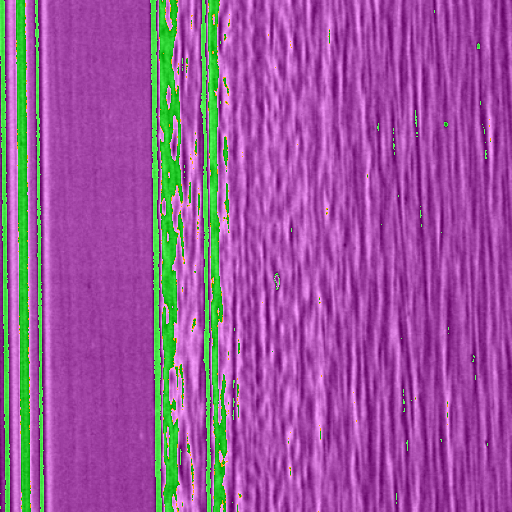

In [46]:
a = Image.fromarray((train_ds[0]["pixel_values"]*255).astype(np.uint8).T)
display(a)